In [1]:
# imports
import math
import numpy as np
import pandas as pd
from scipy import stats
import random
import matplotlib.pyplot as plt
# import mayavi.mlab as mlab
import seaborn as sns

import sys
import json
import shutil

In [2]:
def load_parameters(filepath):
    '''
    Loads input and output directories
    '''
    with open(filepath) as fp:
        parameter = json.load(fp)

    return parameter

sys.path.insert(0, '../src')

In [3]:
# Seating_chart_builder

n = 28
seats = {str(i): 0 for i in range(n)}
seats_28 = seats.copy()
for key, val in seats.items():    
    if int(key)%4 == 0:
        x = int(7/2 * int(key) + 2)
        y = 3
            
    elif int(key)%4 == 1:
        x = int(7/2 * (int(key) - 1) + 2)
        y = 16
        
    elif int(key)%4 == 2:
        x = int(7/2 * int(key) + 2)
        y = 8
        
    else:
        x = int(7/2 * (int(key) - 1) + 2)
        y = 21
    seats_28[key] = [x, y]
    
n_ = 56
seats_ = {str(i): 0 for i in range(n_)}
seats_56 = seats_.copy()
for key, val in seats_.items():
    if int(key)%4 == 0:
        x = int(7 * int(key)/4 + 2)
        y = 3
            
    elif int(key)%4 == 1:
        x = int(7 * (int(key) - 1)/4 + 2)
        y = 16
        
    elif int(key)%4 == 2:
        x = int(7 * int(key)/4 -1)
        y = 8
        
    else:
        x = int(7 * (int(key) - 1)/4 -1)
        y = 21
    seats_56[key] = [x, y]
# ----------------------------------------------------------
f_seats = {str(i): [] for i in range(n)}
f_seats_28 = f_seats.copy()
for key, val in seats.items(): 
    if int(key)%4 == 0:
        x = math.floor(int(key)/2)  + math.floor(int(key)/6) + 1
        y = 1
            
    elif int(key)%4 == 1:
        x = math.floor(int(key)/2) + math.floor(int(key)/6) + 1
        y = 4
        
    elif int(key)%4 == 2:
        x = math.floor(int(key)/2) + math.floor(int(key)/6) + 1
        y = 2
        
    else:
        x = math.floor(int(key)/2) + math.floor(int(key)/6) + 1
        y = 5
    f_seats_28[key] = [x, y]
    
f_seats_ = {str(i): [] for i in range(n_)}
f_seats_56 = f_seats_.copy()
for key, val in f_seats_56.items():
    if int(key)%4 == 0:
        x = math.floor(int(key)/4)  + math.floor(int(key)/12) + 1
        y = 1
            
    elif int(key)%4 == 1:
        x = math.floor(int(key) - 1)/4  + math.floor((int(key) - 1)/12) + 1
        y = 4
        
    elif int(key)%4 == 2:
        x = math.floor(int(key)/4)  + math.floor(int(key)/12) + 1
        y = 2
        
    else:
        x = math.floor((int(key) -1)/4)  + math.floor((int(key) - 1)/12) + 1
        y = 5
    f_seats_56[key] = [int(x), int(y)]

In [4]:
# LOCAL IMPORT
# import data from other files
from bus import bus_sim, trip_stats
from classroom import func
from infection import generate_infectivity_curves, plot_infectivity_curves, return_aerosol_transmission_rate



# import functions from other files

# import default parameters
# bus_params = load_parameters('../config/bus_params.json')

# class_params = load_parameters('../config/class_params.json')

C:\Users\Bailey\Desktop\Github files\OneRoomABM\notebooks cwd


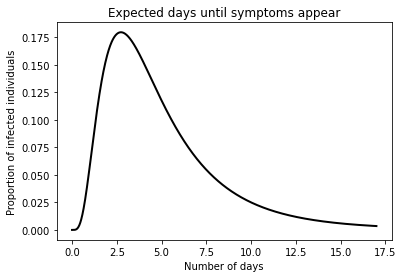

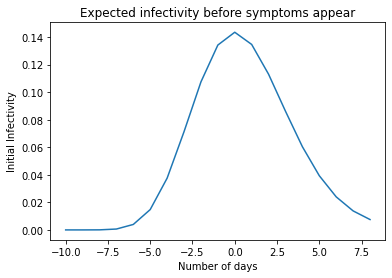

In [5]:
# INFECTION

# plot % infectivity based on day- lognormal w/ % chance of infectivity

proxy_vars = generate_infectivity_curves()
out = plot_infectivity_curves(proxy_vars)
# proxy_vars

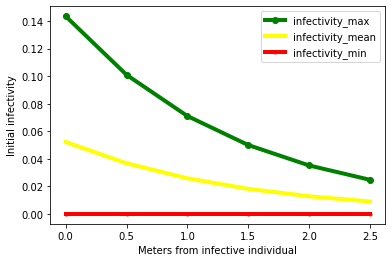

In [6]:
# print('max', max(out))
# print('min', min(out))
# print('mean', np.mean(out))
dist_plot_x = np.arange(0, 3, 0.5)
def chu(dist, inf):
    return (1 / (2.02 ** dist)) * inf
max_list = []
min_list = []
mean_list = []



for i in dist_plot_x:
    max_list.append(chu(i, max(out.gamma)))
    min_list.append(chu(i, min(out.gamma)))
    mean_list.append(chu(i, np.mean(out.gamma)))
    

df = pd.DataFrame({'meters': dist_plot_x, 'infectivity_max': max_list, 'infectivity_mean': mean_list, 'infectivity_min': min_list})

plt.plot('meters', 'infectivity_max', data=df, marker='o', color='green', linewidth=4)
plt.plot('meters', 'infectivity_mean', data=df, marker='', color='yellow', linewidth=4)
plt.plot('meters', 'infectivity_min', data=df, marker='.', color='red', linewidth=4)    
plt.legend()
plt.xlabel('Meters from infective individual')
plt.ylabel('Initial infectivity')


# plt.show() 
plt.savefig("distance_infective.png", dpi=300)
# replace with plt.savefig()

In [7]:
############ initialize variables

# setup default infection parameters
floor_area = 86.02  # ft2 # 11.4 m * 2.3 m * (m^2->ft^2) = 86.02 ~= 86 ft^2
mean_ceiling_height = 12  # ft # 1.85 m -> ft = 6.06 ~= 6 ft
air_exchange_rate = 20  # /hr (air changes per hour (ACH)) #moving bus mph average


##Assumed Parameter Identified as 0.2 for Classrooms, 1.0 for outdoors#
# and .5 for buses with windows open
primary_outdoor_air_fraction = 0.5  # 1.0 = natural ventilation
aerosol_filtration_eff = 0  # >0.9997 HEPA, =0.2-0.9 MERVs, =0 no filter

#Average daily RH for San Diego is 69%
relative_humidity = 0.69 
physical_params = [floor_area, mean_ceiling_height, air_exchange_rate, primary_outdoor_air_fraction,
                        aerosol_filtration_eff, relative_humidity]

# Physiological Parameters
breathing_flow_rate = 0.5  # m3/hr
max_aerosol_radius = 2  # micrometers
physio_params = [breathing_flow_rate, max_aerosol_radius]

# Disease Parameters
exhaled_air_inf = 30  # infection quanta/m3, changes with acitivity type.
max_viral_deact_rate = 0.3  # /hr
disease_params = [exhaled_air_inf, max_viral_deact_rate]

# Precautionary Parameters
mask_passage_prob = .1 # 1 = no masks, ~0.1 cloth, <0.05 N95
risk_tolerance = 0.1  # expected transmissions per infector
prec_params = [mask_passage_prob, risk_tolerance]
############

In [49]:
select_dict = load_parameters('../config/neighbor_logic.json')

def get_neighbor_incoming(x, y, old):
    neighb = []
    count = 0
    x_max = old.shape[0] - 1
    y_max = old.shape[1] - 1

    if x == 0:
        x_range = [0, 1]
    elif x == x_max:
        x_range = [-1, 0]
    else:
        x_range = [-1, 0, 1]

    if y == 0:
        y_range = [0, 1]
    elif y == y_max:
        y_range = [-1, 0]
    else:
        y_range = [-1, 0, 1]

    this_val = old[x][y]
    this_direction = bus_flow_direction[x][y]
    this_velocity = bus_flow_velocity[x][y]

    dict_iterate_count = 0
    for i in x_range:
        for j in y_range:
            dict_iterate_count += 1
            if i == 0 and j == 0:
                # disperse .1 to all 8 neighboring squares
                pass
            else:
                # factors in neighboring cell
                direction = bus_flow_direction[x + i][y + j]

                # update direction function

                if direction in select_dict[str([i, j])]:
                    idx = select_dict[str([i, j])].index(direction)
                    vel_idx = bus_flow_velocity[x + i][y + j]
                    magnitude = select_dict["mag_array"][vel_idx] * select_dict["risk_array"][idx]
                    value = old[x + i][y + j]
                    neighb.append(value * magnitude)
                # else nothing moves in

    if len(neighb) > 0:
        new_val = this_val * (1 - .2 * this_velocity) + np.mean(neighb)
    else:
        new_val = this_val
    return new_val

def air_effects(i, j, oldQ):
    '''
    i, j: x y locations

    oldQ: old quanta at that cube

    get neighbors directions and magnitude
    determine % in and % out
    '''
    # windows
    if j < 2 or j > 4:
        new = oldQ * .85

    # ceiling vents
    if (i > 6 and i < 9) or (i > 12 and i < 15):
        new = oldQ * .6
    else:
        new = 1.1 * oldQ
    return new

def make_new_heat(old, bus_pos, init_infected_ = None):
    '''
    1 minute step used to calculate concentration_distribution iteratively
    '''
    if init_infected_:
        pass
    else:
        init_infected_ = np.random.choice(list(bus_pos.keys()))

    ############## GET CORRECT FLOW POSITIONS *******

    initial_loc = bus_pos[init_infected_]
    new = old.copy()
    out = old.copy()
    for i in range(len(old)):
        for j in range(len(old[i])):
            dist = math.sqrt(((initial_loc[0] - i)**2) + (initial_loc[1] - j)**2)
            new_val = old[i][j] + (1/(2.02 ** dist))
            new[i][j] = new_val

            ##################################################
    for i in range(len(old)):
        for j in range(len(old[i])):
            neighbor_val = np.mean(get_neighbor_incoming(i, j, new))
            air_val = air_effects(i, j, neighbor_val)
            out[i][j] = air_val
    return out, init_infected_

bus_flow_direction = np.array([[1, 1, 1, 2, 3, 4, 4],
              [1, 4, 7, 8, 9, 9, 6],
              [4, 7, 7, 8, 9, 9, 6],
              [4, 4, 5, 2, 5, 4, 4],
              [8, 5, 5, 2, 5, 5, 8], #
              [1, 1, 1, 2, 5, 6, 6],
              [1, 1, 2, 2, 5, 6, 6],
              [1, 1, 2, 2, 3, 3, 6],
              [5, 5, 5, 2, 5, 5, 5],
              [1, 1, 1, 2, 3, 3, 3], #
              [1, 1, 2, 2, 2, 3, 3],
              [1, 1, 2, 2, 2, 3, 3],
              [1, 1, 2, 2, 2, 3, 3],
              [1, 1, 2, 2, 2, 3, 3],
              [1, 5, 5, 2, 2, 3, 3], #
              [1, 1, 1, 2, 2, 3, 3],
              [1, 1, 1, 2, 2, 3, 3],
              [1, 1, 1, 2, 3, 6, 6],
              [1, 1, 2, 2, 3, 3, 6],
              [1, 2, 2, 2, 3, 3, 6], #
              [4, 4, 4, 5, 6, 6, 6],
              [2, 2, 2, 5, 5, 5, 5],
              [2, 2, 5, 8, 2, 2, 2]])
bus_flow_velocity = np.array([[3,3,2,1,1,0,1],
    [1,0,1,2,3,2,2],
    [1,2,1,0,1,2,2],
    [2,1,0,0,0,1,1],
    [2,1,0,0,0,1,1], #
    [2,1,0,0,0,0,1],
    [1,1,0,0,0,0,1],
    [1,2,1,1,0,0,0],
    [0,1,2,1,0,1,2],
    [0,0,0,0,0,0,1], #
    [2,2,2,2,2,1,1],
    [3,2,2,2,2,2,2],
    [2,0,0,0,0,1,2],
    [1,2,2,2,2,2,1],
    [1,1,2,2,2,1,1], #
    [1,1,2,2,2,1,1],
    [1,1,1,1,1,1,1],
    [2,2,2,2,2,2,2],
    [2,2,3,3,3,2,2],
    [1,1,2,2,2,1,1], #
    [1,1,2,2,2,1,1],
    [1,1,1,1,1,1,1],
    [1,1,1,1,0,0,0],
    [1,1,0,0,0,0,0]])
#


def concentration_distribution(num_steps, num_sims, bus_flow_pos):
    '''
    Simulate distribution of concentration after
    30 steps
    100 runs
    random initial student/infectivity


    '''
    nothings = np.zeros(bus_flow_direction.shape)
    temp, initial = make_new_heat(nothings, bus_flow_pos, init_infected_=None)
    temp_array = []

    for step in range(num_steps):
        temp, initial = make_new_heat(temp, bus_flow_pos, init_infected_=None)
        print(temp, 'temp')
        temp_array.append(temp)
        
        
    return temp_array[-1]
bus_flow_pos = load_parameters('../config/seating_28.json')
n_sims=10
concentration_array = concentration_distribution(n_sims, n_sims, bus_flow_pos)
out_matrix = np.array(np.zeros(shape=concentration_array[0].shape))
max_val = 0


for conc in range(len(concentration_array)):
    for y in range(concentration_array[conc].shape[0]):
        for x in range(concentration_array[conc].shape[1]):
            out_matrix[y][x] += (concentration_array[conc][y][x] / len(concentration_array))
            if  (concentration_array[conc][y][x] / len(concentration_array)) > max_val:
                max_val =  (concentration_array[conc][y][x] / len(concentration_array))

concentration_ = out_matrix
for conc in range(len(concentration_array)):
    for y in range(concentration_array[conc].shape[0]):
        for x in range(concentration_array[conc].shape[1]):
            out_matrix[y][x] / max_val

[[6.01778393e-08 1.09421452e-07 3.00178811e-07 7.10072061e-07
  1.28041632e-06 3.02505302e-06 4.19850955e-06]
 [1.40239643e-07 3.19788149e-07 4.83039018e-07 7.29107413e-07
  9.20414497e-07 2.65868314e-06 4.57396739e-06]
 [1.77038125e-07 2.57046512e-07 6.10445044e-07 1.48605702e-06
  2.38234212e-06 3.74272259e-06 6.80073111e-06]
 [1.69988313e-07 3.92621100e-07 9.19614680e-07 1.82222357e-06
  3.66593904e-06 6.07522892e-06 1.13657787e-05]
 [2.16895639e-07 4.77500865e-07 1.11265795e-06 2.17249297e-06
  4.35449082e-06 7.51753942e-06 1.32418862e-05]
 [2.44898256e-07 5.43593985e-07 1.30888587e-06 2.57627187e-06
  5.11281775e-06 1.12055051e-05 1.63417825e-05]
 [3.55498132e-07 6.29513197e-07 1.53764700e-06 3.01700906e-06
  5.91833941e-06 1.23594334e-05 1.96051566e-05]
 [2.02884561e-07 2.97529796e-07 7.83296744e-07 1.44541687e-06
  3.58286454e-06 7.39331211e-06 1.48996429e-05]
 [2.41944543e-07 3.88818427e-07 6.28337636e-07 1.52698047e-06
  3.80096285e-06 6.30778382e-06 9.50696849e-06]
 [4.986748

IndexError: tuple index out of range

In [42]:
# BUS

# --> Airavata: implement ############# section ########## with user input instead of loop

# initialize: parameter loops

windows = ['up', 'down']
num_students = [28, 56]
masks = [1, .9, .8]
num_sims = 10
trip_length = 60


# table output: % chance of >= 1 infection over 1 bus trip

out_array = [[], [], []]
final_array = [[], [], []]


out_matrix = np.array(np.zeros(shape=bus_flow_direction.shape))

for w in range(len(windows)):

    for n in range(len(num_students)):
        
        for m in range(len(masks)):
            # windows up vs down # extrapolated from ACH ratio for open windows on bus
            # and open vs closed windows in a classroom (prior research)
            ##### verify this #####
            if windows[w] == 'up': # effective ACH = 5
                win_effect = 0.25
            if windows[w] == 'down': # effective ACH = 20
                win_effect = 1
            # bus_aerosol moved to bus.py

#             bus_aerosol = return_aerosol_transmission_rate(floor_area, mean_ceiling_height,
#                                     air_exchange_rate * win_effect,
#                                     aerosol_filtration_eff, relative_humidity, breathing_flow_rate,
#                                     exhaled_air_inf, max_viral_deact_rate, mask_passage_prob,
#                                     max_aerosol_radius=2, primary_outdoor_air_fraction=0.2)
            
    
            # conc is not averaged yet
            bus_trip, conc, avg_conc, chance_nonzero = bus_sim(windows[w], num_students[n], masks[m], num_sims, trip_length, '56')
            # this is an array of transmission % for each student on the trip
        
            # reference array
            out_array[m].append([windows[w],num_students[n],masks[m]]) # append value
            final_array[m].append(chance_nonzero)
            
            for y in range(len(avg_conc)):
                for x in range((len(avg_conc[0]))):
                    out_matrix[y][x] += (avg_conc[y][x]) / (len(windows) * len(num_students) * len(masks))
        
out_df = pd.DataFrame(out_array)
out_df.columns = ['WinUp28', 'WinUp56', 'WinDown28', 'WinDown56']
out_df.index = ['100%', '90%', '80%'] # mask wearing rate
out_df

# initialize: scatter

# output: scatterplot of distance from initial (X) vs Likelihood of infection (Y)
# Y: each point = 1 student, averaged over 100 reruns (random initial student, random infectivity)




# initialize: close_neighbors

# 5 students: KDEplot of % likelihood of infection over 1 trip


C:\Users\Bailey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Bailey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,WinUp28,WinUp56,WinDown28,WinDown56
100%,"[up, 28, 1]","[up, 56, 1]","[down, 28, 1]","[down, 56, 1]"
90%,"[up, 28, 0.9]","[up, 56, 0.9]","[down, 28, 0.9]","[down, 56, 0.9]"
80%,"[up, 28, 0.8]","[up, 56, 0.8]","[down, 28, 0.8]","[down, 56, 0.8]"


<AxesSubplot:ylabel='Density'>

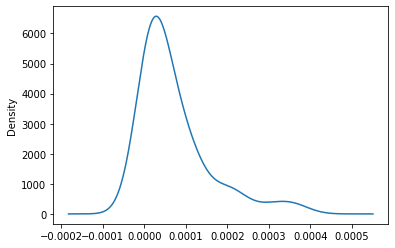

In [43]:
pd.Series(bus_trip).plot.kde()

In [44]:
conc[0].shape

(23, 7)

In [45]:
final_df = pd.DataFrame(final_array)
final_df.columns =['WinUp28', 'WinUp56', 'WinDown28', 'WinDown56']
final_df.index = ['100%', '90%', '80%'] # mask wearing rate
final_df

,WinUp28,WinUp56,WinDown28,WinDown56
100%,0.016788,0.041460,0.023599,0.046571
90%,0.015802,0.039889,0.022687,0.037077
80%,0.020966,0.042014,0.014838,0.046667


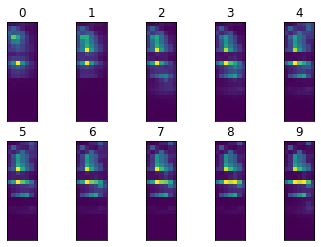

In [46]:
fig, axs = plt.subplots((math.floor(len(conc) / 5)), (math.floor(len(conc) / 2)), edgecolor='k')

axs = axs.ravel()
avg_array = []

for c in range(len(conc)):
    axs[c].matshow(conc[c])
    axs[c].tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False, labeltop=False)
    axs[c].set_title(c)
            

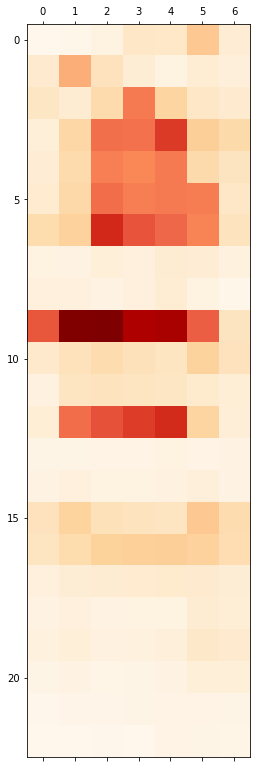

In [47]:
plt.matshow(out_matrix, cmap="OrRd")